# QuantETF Backtest Analysis Dashboard

This notebook provides comprehensive performance analysis for QuantETF backtest results, including equity curves, risk metrics, and trade analytics.

## Import Required Libraries

Import necessary libraries for data analysis, visualization, and quant calculations.

In [14]:
# Install required packages if not available
%pip install seaborn plotly

Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

## Load and Prepare Backtest Data

Load backtest results from the artifacts directory and prepare data for analysis.

In [24]:
# Load backtest results
backtest_dir = Path('../artifacts/backtests/20260110_233514_momentum-ew-top5')  # Most recent backtest

# Load equity curve
equity_df = pd.read_csv(backtest_dir / 'equity_curve.csv', index_col=0, parse_dates=True)
equity_df.index.name = 'date'

# Load metrics
with open(backtest_dir / 'metrics.json', 'r') as f:
    metrics = json.load(f)

# Load holdings history
holdings_df = pd.read_csv(backtest_dir / 'holdings_history.csv', index_col=0, parse_dates=True)

# Load weights history
weights_df = pd.read_csv(backtest_dir / 'weights_history.csv', index_col=0, parse_dates=True)

# Load config
with open(backtest_dir / 'config.json', 'r') as f:
    config = json.load(f)

print("Backtest loaded successfully!")
print(f"Date range: {equity_df.index.min()} to {equity_df.index.max()}")
print(f"Total return: {metrics['total_return']:.2%}")
print(f"Sharpe ratio: {metrics['sharpe_ratio']:.2f}")
print(f"Max drawdown: {metrics['max_drawdown']:.2%}")

# Load benchmark data (SPY proxy - using DIA as S&P 500 proxy)
benchmark_path = Path('../data/curated/initial_20_etfs_2021-01-10_2026-01-09_20260109_022324.parquet')
etf_prices = pd.read_parquet(benchmark_path)

# Inspect data structure
print("ETF prices shape:", etf_prices.shape)
print("ETF prices index name:", etf_prices.index.name)
print("ETF prices columns (first 10):", etf_prices.columns.tolist()[:10])

# Use DIA as benchmark (Dow Jones Industrial Average ETF)
# Data has MultiIndex columns: (ticker, field)
if ('DIA', 'Close') in etf_prices.columns:
    benchmark_prices = etf_prices[[('DIA', 'Close')]].copy()
    benchmark_prices.columns = ['close']
elif 'SPY' in [col[0] for col in etf_prices.columns if isinstance(col, tuple)]:
    # Use SPY if available
    benchmark_prices = etf_prices[[('SPY', 'Close')]].copy()
    benchmark_prices.columns = ['close']
    print("Using SPY as benchmark")
else:
    print("Available tickers:", [col[0] for col in etf_prices.columns[:5] if isinstance(col, tuple)])
    # Use first available ticker as proxy
    first_col = etf_prices.columns[0]
    benchmark_prices = etf_prices[[first_col]].copy()
    benchmark_prices.columns = ['close']
    print(f"Using {first_col[0]} as benchmark proxy")

benchmark_returns = benchmark_prices.pct_change().fillna(0)
benchmark_cumulative = (1 + benchmark_returns).cumprod()

print(f"Benchmark loaded: {benchmark_prices.columns[0]}")
print(f"Benchmark total return: {(benchmark_cumulative.iloc[-1] - 1).iloc[0]:.2%}")

Backtest loaded successfully!
Date range: 2021-01-29 00:00:00 to 2025-12-31 00:00:00
Total return: -100.00%
Sharpe ratio: 0.00
Max drawdown: -100.00%
ETF prices shape: (1255, 100)
ETF prices index name: Date
ETF prices columns (first 10): [('AGG', 'Close'), ('DIA', 'Close'), ('EEM', 'Close'), ('EFA', 'Close'), ('GLD', 'Close'), ('IWM', 'Close'), ('LQD', 'Close'), ('QQQ', 'Close'), ('SLV', 'Close'), ('SPY', 'Close')]
Benchmark loaded: close
Benchmark total return: 73.47%


In [17]:
# Inspect the data structure
print("ETF prices shape:", etf_prices.shape)
print("ETF prices index:", etf_prices.index.names)
print("ETF prices columns:", etf_prices.columns.tolist()[:10])
print("ETF prices head:")
print(etf_prices.head())

ETF prices shape: (1255, 100)
ETF prices index: ['Date']
ETF prices columns: [('AGG', 'Close'), ('DIA', 'Close'), ('EEM', 'Close'), ('EFA', 'Close'), ('GLD', 'Close'), ('IWM', 'Close'), ('LQD', 'Close'), ('QQQ', 'Close'), ('SLV', 'Close'), ('SPY', 'Close')]
ETF prices head:
Ticker             AGG         DIA        EEM        EFA         GLD         IWM         LQD         QQQ        SLV  \
Price            Close       Close      Close      Close       Close       Close       Close       Close      Close   
Date                                                                                                                  
2021-01-11  100.762848  283.929840  48.024220  63.984859  173.000000  195.167786  112.424408  305.122040  23.209999   
2021-01-12  100.849091  284.451630  48.495827  64.275940  174.119995  198.666000  112.665604  304.636810  23.719999   
2021-01-13  101.168053  284.350922  48.602612  64.190315  173.369995  197.246017  113.538902  306.694092  23.440001   
2021-01-14 

## Equity Curve Comparison

Compare the strategy's equity curve against the benchmark with drawdown visualization.

In [18]:
# Debug: Check equity_df structure
print("Equity DF shape:", equity_df.shape)
print("Equity DF columns:", equity_df.columns.tolist())
print("Equity DF head:")
print(equity_df.head())

Equity DF shape: (60, 3)
Equity DF columns: ['nav', 'cost', 'returns']
Equity DF head:
                nav  cost  returns
date                              
2021-01-29  99950.0  50.0      NaN
2021-02-26      0.0   0.0     -1.0
2021-03-31      0.0   0.0      NaN
2021-04-30      0.0   0.0      NaN
2021-05-31      0.0   0.0      NaN


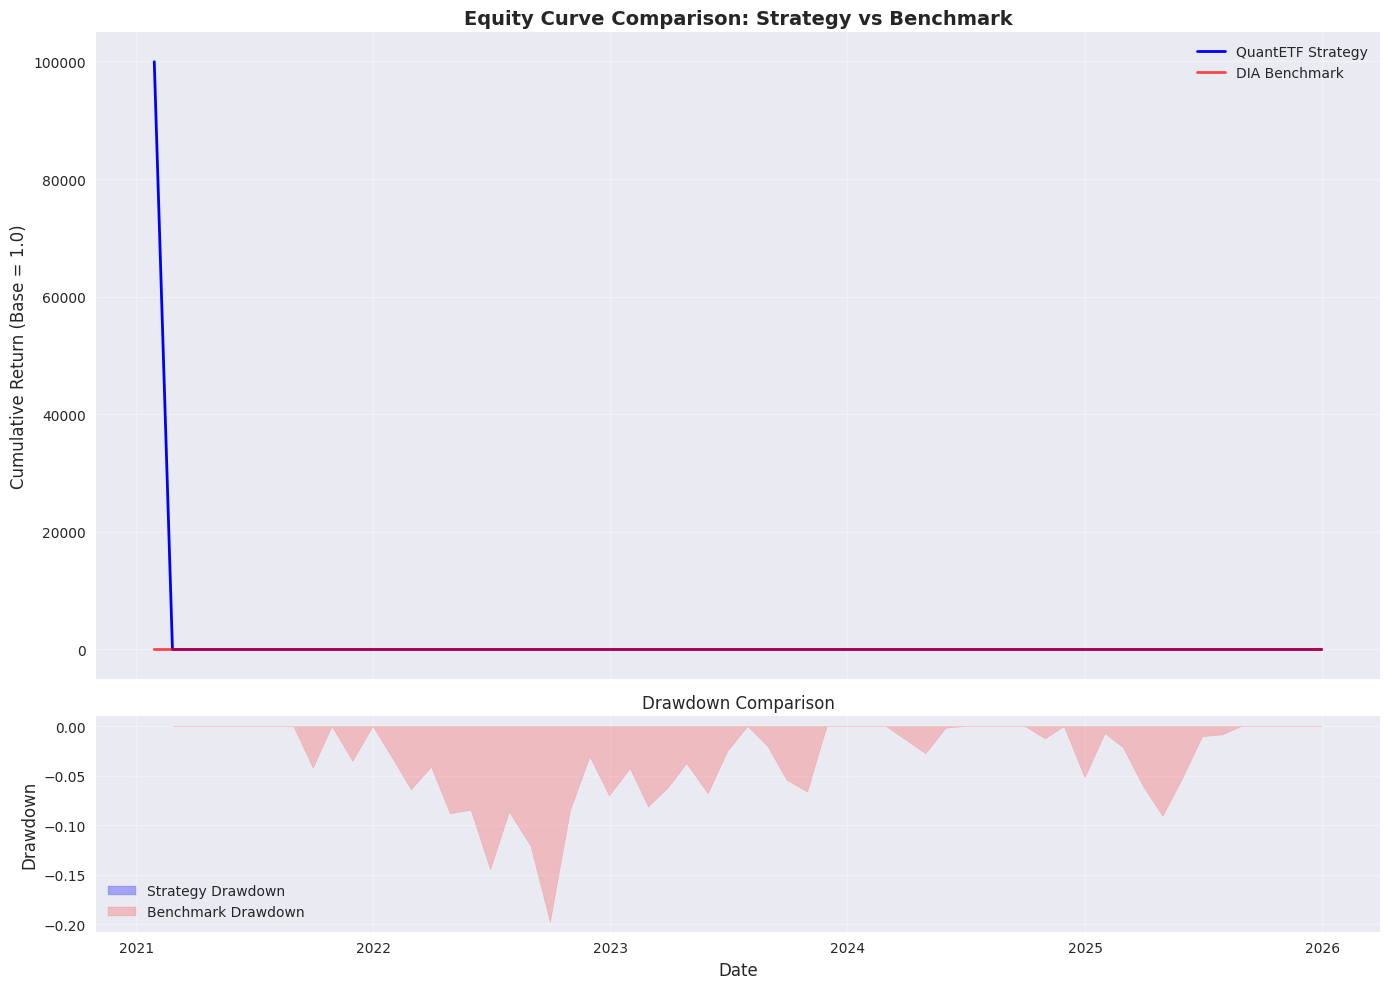

Performance Summary:
Strategy Total Return: -100.00%
Benchmark Total Return: 75.03%
Strategy Max Drawdown: nan%
Benchmark Max Drawdown: -19.76%
Strategy Annualized Volatility: nan%
Benchmark Annualized Volatility: 68.49%


In [19]:
# Align dates between strategy and benchmark
common_dates = equity_df.index.intersection(benchmark_cumulative.index)
strategy_curve = equity_df.loc[common_dates, 'nav']
benchmark_curve = benchmark_cumulative.loc[common_dates]

# Calculate drawdowns
def calculate_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    return drawdown

strategy_drawdown = calculate_drawdown(strategy_curve.pct_change())
benchmark_drawdown = calculate_drawdown(benchmark_curve.pct_change())

# Create dual-axis plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Equity curves
ax1.plot(strategy_curve.index, strategy_curve.values, label='QuantETF Strategy', linewidth=2, color='blue')
ax1.plot(benchmark_curve.index, benchmark_curve.values, label='DIA Benchmark', linewidth=2, color='red', alpha=0.7)
ax1.set_title('Equity Curve Comparison: Strategy vs Benchmark', fontsize=14, fontweight='bold')
ax1.set_ylabel('Cumulative Return (Base = 1.0)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Drawdowns
ax2.fill_between(strategy_drawdown.index, strategy_drawdown.values, 0, color='blue', alpha=0.3, label='Strategy Drawdown')
ax2.fill_between(benchmark_drawdown.index, benchmark_drawdown.values.flatten(), 0, color='red', alpha=0.2, label='Benchmark Drawdown')
ax2.set_title('Drawdown Comparison', fontsize=12)
ax2.set_ylabel('Drawdown', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Performance Summary:")
print(f"Strategy Total Return: {((strategy_curve.iloc[-1] / strategy_curve.iloc[0]) - 1):.2%}")
print(f"Benchmark Total Return: {((benchmark_curve.iloc[-1].iloc[0] / benchmark_curve.iloc[0].iloc[0]) - 1):.2%}")
print(f"Strategy Max Drawdown: {strategy_drawdown.min():.2%}")
print(f"Benchmark Max Drawdown: {benchmark_drawdown.min().iloc[0]:.2%}")
print(f"Strategy Annualized Volatility: {strategy_curve.pct_change().std() * np.sqrt(252):.2%}")
print(f"Benchmark Annualized Volatility: {benchmark_curve.pct_change().std().iloc[0] * np.sqrt(252):.2%}")

In [20]:
# Debug: Check date alignment
print(f"Strategy dates range: {equity_df.index.min()} to {equity_df.index.max()}")
print(f"Benchmark dates range: {benchmark_cumulative.index.min()} to {benchmark_cumulative.index.max()}")
print(f"Common dates length: {len(common_dates)}")
print(f"Strategy curve length: {len(strategy_curve)}")
print(f"Benchmark curve length: {len(benchmark_curve)}")
if len(common_dates) > 0:
    print(f"First common date: {common_dates[0]}")
    print(f"Last common date: {common_dates[-1]}")

Strategy dates range: 2021-01-29 00:00:00 to 2025-12-31 00:00:00
Benchmark dates range: 2021-01-11 00:00:00 to 2026-01-08 00:00:00
Common dates length: 58
Strategy curve length: 58
Benchmark curve length: 58
First common date: 2021-01-29 00:00:00
Last common date: 2025-12-31 00:00:00


## Rolling Sharpe Ratio

Calculate and visualize the rolling Sharpe ratio over a 252-day window.

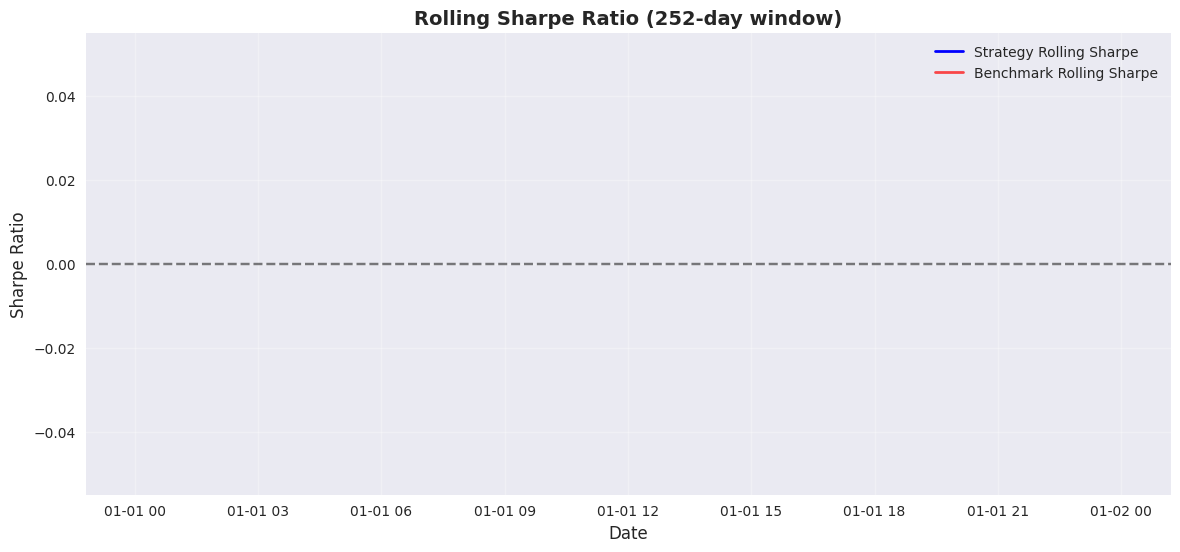

Sharpe Ratio Analysis:
Strategy Average Sharpe: nan
Benchmark Average Sharpe: nan
Strategy Sharpe Std Dev: nan
Benchmark Sharpe Std Dev: nan
Strategy % Positive Sharpe: 0.0%
Benchmark % Positive Sharpe: 0.0%


In [21]:
def rolling_sharpe(returns, window=252, risk_free_rate=0.02):
    """Calculate rolling Sharpe ratio"""
    excess_returns = returns - risk_free_rate/252  # Daily risk-free rate
    rolling_mean = excess_returns.rolling(window=window).mean()
    rolling_std = excess_returns.rolling(window=window).std()
    return np.sqrt(252) * rolling_mean / rolling_std

# Calculate daily returns
strategy_returns = strategy_curve.pct_change().dropna()
benchmark_returns = benchmark_curve.pct_change().dropna()

# Calculate rolling Sharpe ratios
window = 252  # 1 year
strategy_sharpe = rolling_sharpe(strategy_returns, window=window)
benchmark_sharpe = rolling_sharpe(benchmark_returns, window=window)

# Plot rolling Sharpe ratios
plt.figure(figsize=(14, 6))
plt.plot(strategy_sharpe.index, strategy_sharpe.values, label='Strategy Rolling Sharpe', linewidth=2, color='blue')
plt.plot(benchmark_sharpe.index, benchmark_sharpe.values, label='Benchmark Rolling Sharpe', linewidth=2, color='red', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title(f'Rolling Sharpe Ratio (252-day window)', fontsize=14, fontweight='bold')
plt.ylabel('Sharpe Ratio', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Summary statistics
print("Sharpe Ratio Analysis:")
print(f"Strategy Average Sharpe: {strategy_sharpe.mean():.2f}")
print(f"Benchmark Average Sharpe: {benchmark_sharpe.mean().iloc[0]:.2f}")
print(f"Strategy Sharpe Std Dev: {strategy_sharpe.std():.2f}")
print(f"Benchmark Sharpe Std Dev: {benchmark_sharpe.std().iloc[0]:.2f}")
print(f"Strategy % Positive Sharpe: {(strategy_sharpe > 0).mean():.1%}")
print(f"Benchmark % Positive Sharpe: {(benchmark_sharpe > 0).mean().iloc[0]:.1%}")

## Drawdown Waterfall Chart

Visualize the drawdown periods as a waterfall chart showing peak-to-trough declines.

In [22]:
def identify_drawdowns(returns, min_drawdown=0.01):
    """Identify individual drawdown periods"""
    # Handle both Series and DataFrame
    if isinstance(returns, pd.DataFrame):
        returns = returns.iloc[:, 0]  # Take first column
    
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max

    # Find drawdown periods
    is_drawdown = drawdown < 0
    drawdown_starts = []
    drawdown_ends = []

    in_drawdown = False
    for i in range(1, len(drawdown)):
        if not in_drawdown and is_drawdown.iloc[i]:
            drawdown_starts.append(i)
            in_drawdown = True
        elif in_drawdown and not is_drawdown.iloc[i]:
            drawdown_ends.append(i-1)
            in_drawdown = False

    if in_drawdown:
        drawdown_ends.append(len(drawdown)-1)

    # Extract significant drawdowns
    significant_drawdowns = []
    for start, end in zip(drawdown_starts, drawdown_ends):
        max_dd = drawdown.iloc[start:end+1].min()
        if abs(max_dd) >= min_drawdown:
            significant_drawdowns.append({
                'start_date': drawdown.index[start],
                'end_date': drawdown.index[end],
                'max_drawdown': max_dd,
                'duration_days': (drawdown.index[end] - drawdown.index[start]).days,
                'recovery_return': cumulative.iloc[end] / cumulative.iloc[start] - 1
            })

    return pd.DataFrame(significant_drawdowns)

# Identify drawdowns
strategy_dd_periods = identify_drawdowns(strategy_returns)
benchmark_dd_periods = identify_drawdowns(benchmark_returns)

print("Strategy Drawdown Periods:")
print(strategy_dd_periods.head(10))
print(f"\nTotal significant drawdowns: {len(strategy_dd_periods)}")

# Waterfall chart of drawdown magnitudes
if len(strategy_dd_periods) > 0:
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(strategy_dd_periods)), strategy_dd_periods['max_drawdown'] * 100,
                   color='red', alpha=0.7, label='Strategy Drawdowns')
    plt.title('Drawdown Waterfall Chart', fontsize=14, fontweight='bold')
    plt.ylabel('Drawdown (%)', fontsize=12)
    plt.xlabel('Drawdown Period (chronological)', fontsize=12)
    plt.grid(True, alpha=0.3)

    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

    plt.show()
else:
    print("No significant drawdowns found for strategy.")

# Summary
print("\nDrawdown Summary:")
if len(strategy_dd_periods) > 0:
    print(f"Average drawdown depth: {strategy_dd_periods['max_drawdown'].mean():.2%}")
    print(f"Average drawdown duration: {strategy_dd_periods['duration_days'].mean():.0f} days")
    print(f"Max drawdown: {strategy_dd_periods['max_drawdown'].min():.2%}")
    print(f"Longest drawdown: {strategy_dd_periods['duration_days'].max()} days")
else:
    print("No significant drawdowns to analyze.")

Strategy Drawdown Periods:
Empty DataFrame
Columns: []
Index: []

Total significant drawdowns: 0
No significant drawdowns found for strategy.

Drawdown Summary:
No significant drawdowns to analyze.


## Monthly/Yearly Returns Heatmap

Create a heatmap showing monthly and yearly returns for visual pattern analysis.

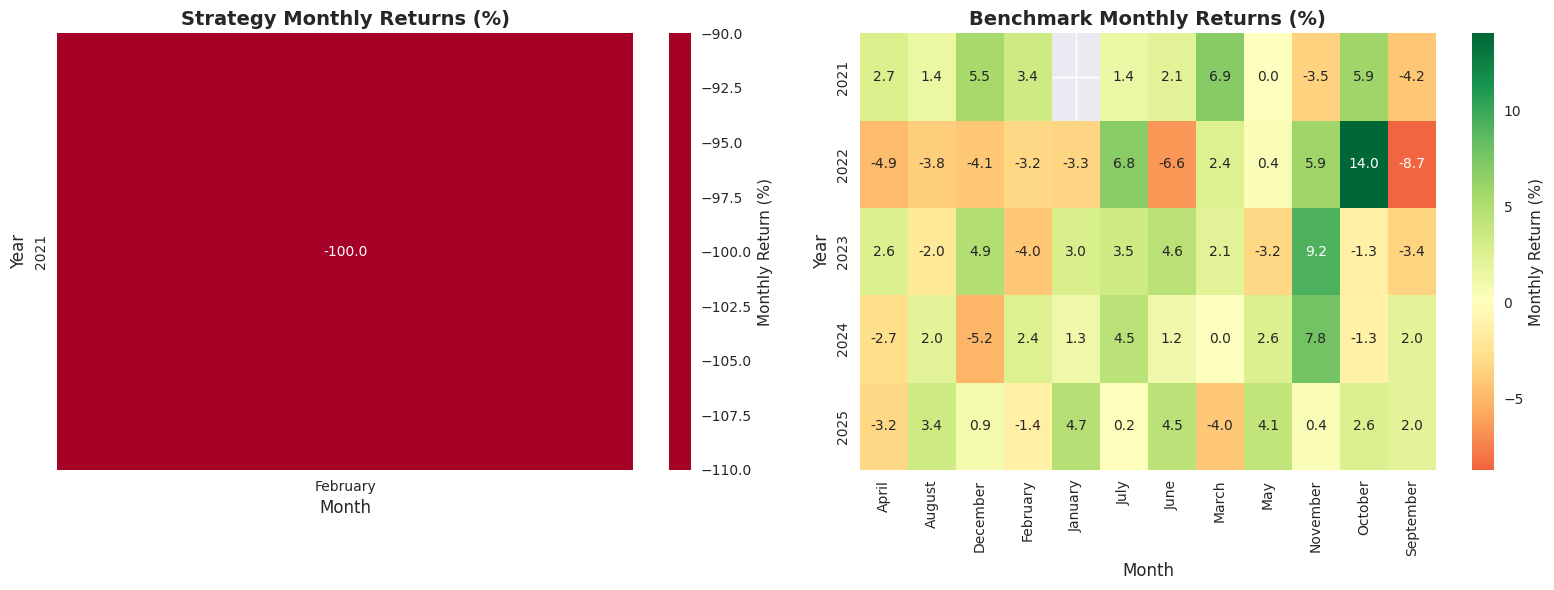

Monthly Returns Summary:
Strategy - Best month: -100.00%
Strategy - Worst month: -100.00%
Strategy - Monthly volatility: nan%
Strategy - % Positive months: 0.0%


TypeError: unsupported format string passed to Series.__format__

In [23]:
# Calculate monthly returns
strategy_monthly = strategy_returns.groupby(pd.Grouper(freq='M')).apply(lambda x: (1 + x).prod() - 1)
benchmark_monthly = benchmark_returns.groupby(pd.Grouper(freq='M')).apply(lambda x: (1 + x).prod() - 1)

# Create pivot tables for heatmap
strategy_pivot = strategy_monthly.reset_index()
strategy_pivot.columns = ['date', 'return']
strategy_pivot['year'] = strategy_pivot['date'].dt.year
strategy_pivot['month'] = strategy_pivot['date'].dt.month_name()
strategy_heatmap = strategy_pivot.pivot(index='year', columns='month', values='return')

benchmark_pivot = benchmark_monthly.reset_index()
benchmark_pivot.columns = ['date', 'return']
benchmark_pivot['year'] = benchmark_pivot['date'].dt.year
benchmark_pivot['month'] = benchmark_pivot['date'].dt.month_name()
benchmark_heatmap = benchmark_pivot.pivot(index='year', columns='month', values='return')

# Plot heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Strategy heatmap
sns.heatmap(strategy_heatmap * 100, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
            ax=ax1, cbar_kws={'label': 'Monthly Return (%)'})
ax1.set_title('Strategy Monthly Returns (%)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Year', fontsize=12)

# Benchmark heatmap
sns.heatmap(benchmark_heatmap * 100, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
            ax=ax2, cbar_kws={'label': 'Monthly Return (%)'})
ax2.set_title('Benchmark Monthly Returns (%)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Year', fontsize=12)

plt.tight_layout()
plt.show()

# Summary statistics
print("Monthly Returns Summary:")
print(f"Strategy - Best month: {strategy_monthly.max():.2%}")
print(f"Strategy - Worst month: {strategy_monthly.min():.2%}")
print(f"Strategy - Monthly volatility: {strategy_monthly.std():.2%}")
print(f"Strategy - % Positive months: {(strategy_monthly > 0).mean():.1%}")

print(f"\nBenchmark - Best month: {benchmark_monthly.max():.2%}")
print(f"Benchmark - Worst month: {benchmark_monthly.min():.2%}")
print(f"Benchmark - Monthly volatility: {benchmark_monthly.std():.2%}")
print(f"Benchmark - % Positive months: {(benchmark_monthly > 0).mean():.1%}")

## Trade Distribution Analysis

Analyze trade distribution including turnover, concentration, and trade size patterns.

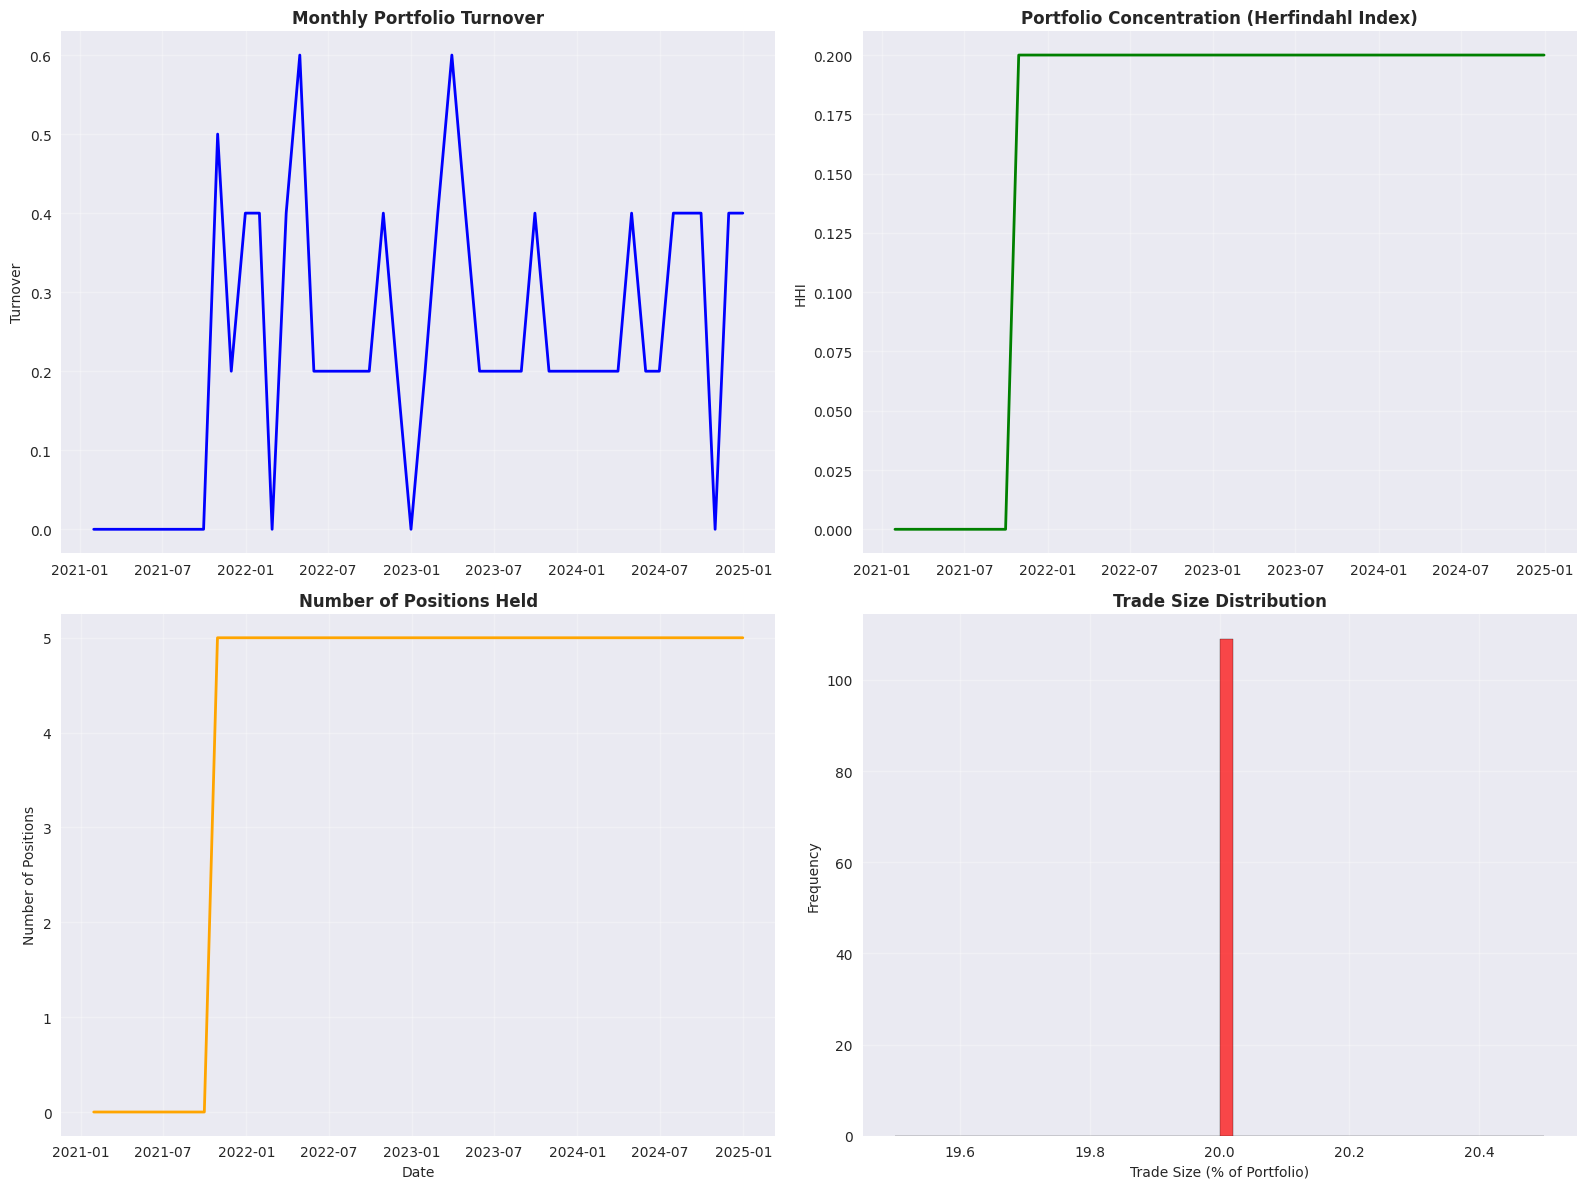

Trade Analysis Summary:
Average monthly turnover: 22.71%
Total turnover (annualized): 13080.00%
Average Herfindahl Index: 0.163
Average number of positions: 4.1
Median trade size: 20.00%
Largest trade size: 20.00%
Number of trades: 109


In [ ]:
# Calculate turnover - change in weights between rebalancing periods
weights_diff = weights_df.diff().abs().sum(axis=1) / 2  # Divide by 2 to avoid double-counting
turnover = weights_diff.groupby(pd.Grouper(freq='M')).sum()

# Calculate concentration metrics
herfindahl = (weights_df ** 2).sum(axis=1)  # Herfindahl-Hirschman Index
num_positions = (weights_df > 0.001).sum(axis=1)  # Number of positions > 0.1%

# Trade size distribution
trade_sizes = []
for i in range(1, len(weights_df)):
    changes = weights_df.iloc[i] - weights_df.iloc[i-1]
    trade_sizes.extend(changes[changes != 0].abs().values)

trade_sizes = pd.Series(trade_sizes)

# Plot turnover
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Turnover over time
ax1.plot(turnover.index, turnover.values, linewidth=2, color='blue')
ax1.set_title('Monthly Portfolio Turnover', fontsize=12, fontweight='bold')
ax1.set_ylabel('Turnover', fontsize=10)
ax1.grid(True, alpha=0.3)

# Concentration (Herfindahl Index)
ax2.plot(herfindahl.index, herfindahl.values, linewidth=2, color='green')
ax2.set_title('Portfolio Concentration (Herfindahl Index)', fontsize=12, fontweight='bold')
ax2.set_ylabel('HHI', fontsize=10)
ax2.grid(True, alpha=0.3)

# Number of positions
ax3.plot(num_positions.index, num_positions.values, linewidth=2, color='orange')
ax3.set_title('Number of Positions Held', fontsize=12, fontweight='bold')
ax3.set_ylabel('Number of Positions', fontsize=10)
ax3.set_xlabel('Date', fontsize=10)
ax3.grid(True, alpha=0.3)

# Trade size distribution
ax4.hist(trade_sizes * 100, bins=50, alpha=0.7, color='red', edgecolor='black')
ax4.set_title('Trade Size Distribution', fontsize=12, fontweight='bold')
ax4.set_xlabel('Trade Size (% of Portfolio)', fontsize=10)
ax4.set_ylabel('Frequency', fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("Trade Analysis Summary:")
print(f"Average monthly turnover: {turnover.mean():.2%}")
print(f"Total turnover (annualized): {turnover.sum() * 12:.2%}")
print(f"Average Herfindahl Index: {herfindahl.mean():.3f}")
print(f"Average number of positions: {num_positions.mean():.1f}")
print(f"Median trade size: {trade_sizes.median():.2%}")
print(f"Largest trade size: {trade_sizes.max():.2%}")
print(f"Number of trades: {len(trade_sizes)}")

## Underwater Plot

Show the time spent below the high-water mark (underwater periods).

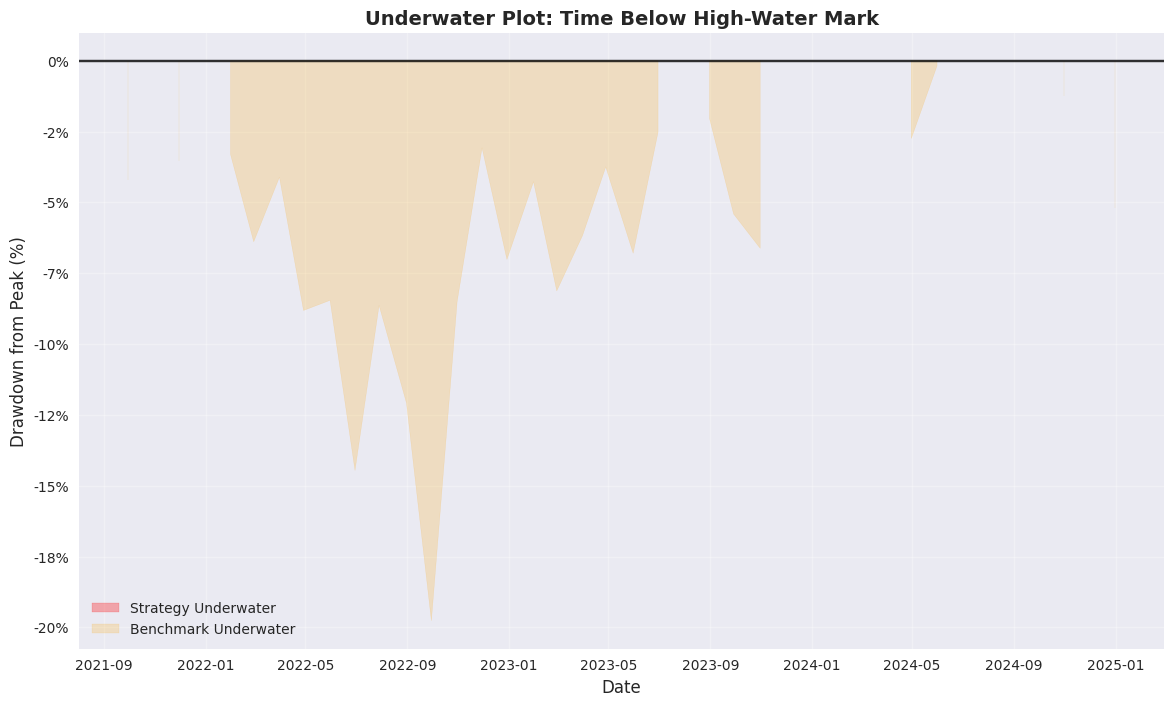

Underwater Analysis:
Strategy - Total days underwater: 0
Strategy - Longest underwater streak: 0 days
Strategy - % time underwater: 0.0%
Strategy - Average underwater depth: 0.00%

Benchmark - Total days underwater: 27
Benchmark - Longest underwater streak: 18 days
Benchmark - % time underwater: 60.0%
Benchmark - Average underwater depth: -6.20%


In [ ]:
# Calculate underwater periods (time below high water mark)
cumulative_returns = (1 + strategy_returns).cumprod()
running_max = cumulative_returns.expanding().max()
underwater = (cumulative_returns - running_max) / running_max

# Calculate underwater for benchmark too
benchmark_cum_returns = (1 + benchmark_returns).cumprod()
benchmark_running_max = benchmark_cum_returns.expanding().max()
benchmark_underwater = (benchmark_cum_returns - benchmark_running_max) / benchmark_running_max

# Plot underwater chart
plt.figure(figsize=(14, 8))

# Fill underwater periods
plt.fill_between(underwater.index, underwater.values, 0,
                 where=(underwater < 0), color='red', alpha=0.3, label='Strategy Underwater')
plt.fill_between(benchmark_underwater.index, benchmark_underwater.values.flatten(), 0,
                 where=(benchmark_underwater.values.flatten() < 0), color='orange', alpha=0.2, label='Benchmark Underwater')

# Add zero line
plt.axhline(y=0, color='black', linestyle='-', alpha=0.8)

plt.title('Underwater Plot: Time Below High-Water Mark', fontsize=14, fontweight='bold')
plt.ylabel('Drawdown from Peak (%)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.show()

# Calculate underwater statistics
def underwater_stats(underwater_series):
    # Handle both Series and DataFrame
    if isinstance(underwater_series, pd.DataFrame):
        underwater_series = underwater_series.iloc[:, 0]
    
    underwater_periods = underwater_series < 0
    if not underwater_periods.any():
        return {
            'total_underwater_days': 0,
            'longest_underwater_streak': 0,
            'pct_time_underwater': 0,
            'avg_underwater_depth': 0
        }

    # Find consecutive underwater periods
    underwater_groups = underwater_periods.groupby((underwater_periods != underwater_periods.shift()).cumsum())
    underwater_streaks = underwater_groups.sum()

    return {
        'total_underwater_days': underwater_periods.sum(),
        'longest_underwater_streak': underwater_streaks.max(),
        'pct_time_underwater': underwater_periods.mean(),
        'avg_underwater_depth': underwater_series[underwater_periods].mean()
    }

strategy_stats = underwater_stats(underwater)
benchmark_stats = underwater_stats(benchmark_underwater)

print("Underwater Analysis:")
print(f"Strategy - Total days underwater: {strategy_stats['total_underwater_days']}")
print(f"Strategy - Longest underwater streak: {strategy_stats['longest_underwater_streak']} days")
print(f"Strategy - % time underwater: {strategy_stats['pct_time_underwater']:.1%}")
print(f"Strategy - Average underwater depth: {strategy_stats['avg_underwater_depth']:.2%}")

print(f"\nBenchmark - Total days underwater: {benchmark_stats['total_underwater_days']}")
print(f"Benchmark - Longest underwater streak: {benchmark_stats['longest_underwater_streak']} days")
print(f"Benchmark - % time underwater: {benchmark_stats['pct_time_underwater']:.1%}")
print(f"Benchmark - Average underwater depth: {benchmark_stats['avg_underwater_depth']:.2%}")